# PCA Dimensionality Reduction Validation

This notebook validates the PCA dimensionality reduction by:
1. Loading the saved PCA model (created by `scripts/apply_pca.py`)
2. Loading datasets before and after PCA
3. Verifying variance explained and component selection
4. Analyzing principal components statistics
5. Checking data preservation (target, split_group, non-numeric columns)
6. Visualizing variance explained and component importance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.insert(0, str(Path.cwd().parent / "src"))

from features.dimensionality_reduction import FeatureReducer

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load PCA Model and Datasets

In [2]:
# Load PCA model
models_dir = Path('../models')
pca_path = models_dir / 'pca.joblib'

if not pca_path.exists():
    raise FileNotFoundError("No PCA model found. Run 'scripts/apply_pca.py' first")

reducer = FeatureReducer.load(str(pca_path))
print(f"PCA model loaded: {pca_path.name}")
print(f"  Variance threshold: {reducer.variance_threshold}")
print(f"  Components selected: {reducer.n_components_selected_}")
print("="*70)

# Load datasets
scaled_file = Path('../data/processed/openfoodfacts_scaled.csv')
pca_file = Path('../data/processed/openfoodfacts_pca.csv')

if not scaled_file.exists():
    raise FileNotFoundError("Scaled dataset not found. Run 'scripts/apply_scaling.py' first")
if not pca_file.exists():
    raise FileNotFoundError("PCA dataset not found. Run 'scripts/apply_pca.py' first")

df_scaled = pd.read_csv(scaled_file)
df_pca = pd.read_csv(pca_file)

print(f"Scaled dataset loaded: {df_scaled.shape[0]:,} rows × {df_scaled.shape[1]} columns")
print(f"PCA dataset loaded: {df_pca.shape[0]:,} rows × {df_pca.shape[1]} columns")
print("="*70)

# Check split_group
if 'split_group' in df_pca.columns:
    print(f"'split_group' column found")
    split_counts = df_pca['split_group'].value_counts()
    print(f"  Train: {split_counts.get('train', 0):,}")
    print(f"  Val:   {split_counts.get('val', 0):,}")
    print(f"  Test:  {split_counts.get('test', 0):,}")
else:
    print("⚠ Warning: 'split_group' column not found")

PCA model loaded: pca.joblib
  Variance threshold: 0.95
  Components selected: 16
Scaled dataset loaded: 98,468 rows × 42 columns
PCA dataset loaded: 98,468 rows × 20 columns
'split_group' column found
  Train: 68,927
  Val:   14,770
  Test:  14,771


## 2. Verify Variance Explained and Component Selection

In [3]:
# Get variance information
explained_variance_ratio = reducer.get_explained_variance_ratio()
cumulative_variance = reducer.get_cumulative_variance()

print("Variance Explained Analysis:")
print("="*70)
print(f"Total variance explained: {cumulative_variance[-1]:.4f} ({cumulative_variance[-1]*100:.2f}%)")
print(f"Target variance threshold: {reducer.variance_threshold*100:.0f}%")
print(f"Components selected: {reducer.n_components_selected_}")
print(f"Original features: {len(reducer.feature_columns_)}")
print(f"Reduction: {len(reducer.feature_columns_) - reducer.n_components_selected_} features ({((len(reducer.feature_columns_) - reducer.n_components_selected_) / len(reducer.feature_columns_) * 100):.1f}%)")
print("="*70)

# Show variance per component (first 10)
print("\nVariance per Component (first 10):")
print("-"*70)
print(f"{'Component':<12} {'Individual':<15} {'Cumulative':<15}")
print("-"*70)
for i in range(min(10, len(explained_variance_ratio))):
    individual = explained_variance_ratio[i] * 100
    cumulative = cumulative_variance[i] * 100
    print(f"PC{i+1:<11} {individual:>6.2f}%        {cumulative:>6.2f}%")
if len(explained_variance_ratio) > 10:
    print(f"... ({len(explained_variance_ratio) - 10} more components)")

Variance Explained Analysis:
Total variance explained: 0.9529 (95.29%)
Target variance threshold: 95%
Components selected: 16
Original features: 37
Reduction: 21 features (56.8%)

Variance per Component (first 10):
----------------------------------------------------------------------
Component    Individual      Cumulative     
----------------------------------------------------------------------
PC1            31.76%         31.76%
PC2            28.44%         60.20%
PC3             5.55%         65.75%
PC4             4.36%         70.11%
PC5             3.70%         73.81%
PC6             3.23%         77.04%
PC7             2.62%         79.66%
PC8             2.39%         82.05%
PC9             2.16%         84.21%
PC10            2.03%         86.24%
... (6 more components)


## 3. Visualize Variance Explained

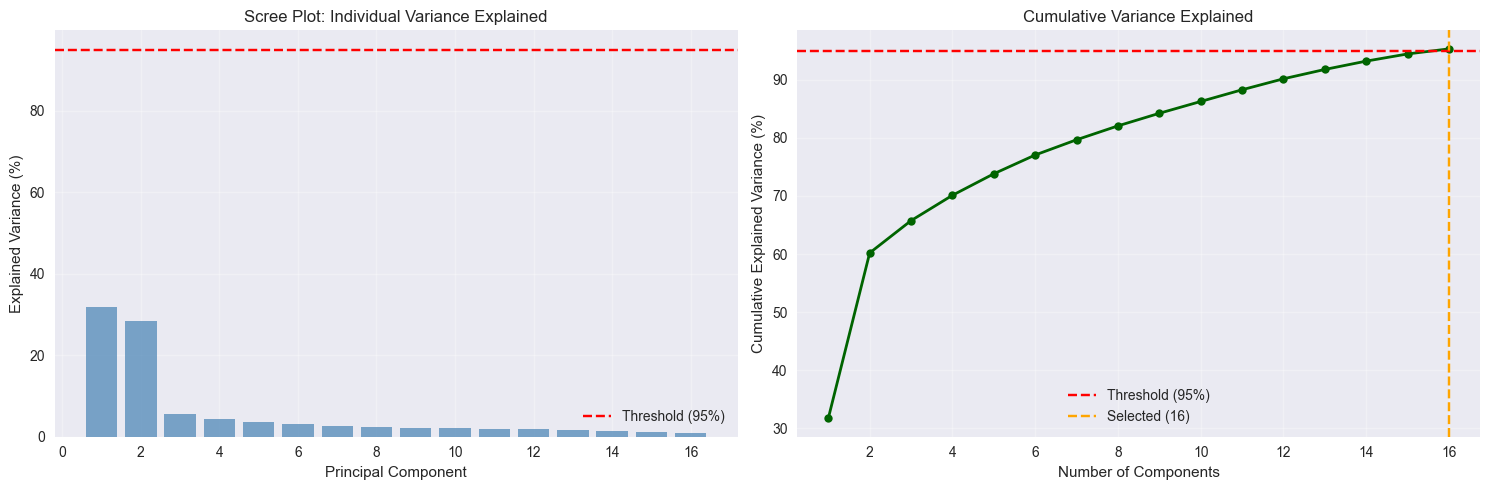

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot (individual variance)
axes[0].bar(range(1, len(explained_variance_ratio) + 1), 
            explained_variance_ratio * 100,
            alpha=0.7, color='steelblue')
axes[0].axhline(y=reducer.variance_threshold * 100, 
                color='r', linestyle='--', 
                label=f'Threshold ({reducer.variance_threshold*100:.0f}%)')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance (%)')
axes[0].set_title('Scree Plot: Individual Variance Explained')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative variance plot
axes[1].plot(range(1, len(cumulative_variance) + 1), 
             cumulative_variance * 100,
             marker='o', linewidth=2, markersize=6, color='darkgreen')
axes[1].axhline(y=reducer.variance_threshold * 100, 
                color='r', linestyle='--', 
                label=f'Threshold ({reducer.variance_threshold*100:.0f}%)')
axes[1].axvline(x=reducer.n_components_selected_, 
                color='orange', linestyle='--', 
                label=f'Selected ({reducer.n_components_selected_})')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance (%)')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Analyze Principal Components Statistics

In [5]:
# Get PCA component columns
pca_cols = [col for col in df_pca.columns if col.startswith('PC')]

if pca_cols:
    print(f"Found {len(pca_cols)} principal components")
    print("="*70)
    
    # Statistics for first 5 components
    stats_data = []
    for col in pca_cols[:5]:
        pc_data = df_pca[col]
        stats_data.append({
            'Component': col,
            'Mean': pc_data.mean(),
            'Std': pc_data.std(),
            'Min': pc_data.min(),
            'Max': pc_data.max(),
            'Variance Explained': f"{explained_variance_ratio[pca_cols.index(col)]*100:.2f}%"
        })
    
    stats_df = pd.DataFrame(stats_data)
    print("\nStatistics for First 5 Principal Components:")
    print("-"*70)
    display(stats_df.round(6))
    
    # Note: PCA components should have mean ≈ 0 and std ≈ 1 (after standardization)
    print("\nExpected: Mean ≈ 0, Std ≈ 1 (for standardized data)")
else:
    print("⚠ No PCA component columns found (expected PC1, PC2, ...)")

Found 16 principal components

Statistics for First 5 Principal Components:
----------------------------------------------------------------------


,Component,Mean,Std,Min,Max,Variance Explained
0,PC1,0.002321,1.065080,-1.740990,2.802179,31.76%
1,PC2,0.001852,1.006809,-1.358520,2.852700,28.44%
2,PC3,-0.000722,0.445179,-1.028674,1.359546,5.55%
3,PC4,-0.000872,0.395654,-1.143358,1.030561,4.36%
4,PC5,0.000398,0.362076,-0.958042,1.014502,3.70%



Expected: Mean ≈ 0, Std ≈ 1 (for standardized data)


## 5. Verify Data Preservation

In [6]:
# Check important columns are preserved
important_cols = ['nutriscore_grade', 'split_group', 'product_name', 'brands']

print("Column Preservation Check:")
print("="*70)
for col in important_cols:
    if col in df_pca.columns:
        print(f"{col}: preserved")
    else:
        print(f"✗ {col}: MISSING")

# Verify target distribution is preserved
if 'nutriscore_grade' in df_pca.columns:
    print("\n" + "="*70)
    print("Target Distribution (should be identical before/after PCA):")
    print("-"*70)
    
    target_before = df_scaled['nutriscore_grade'].value_counts().sort_index()
    target_after = df_pca['nutriscore_grade'].value_counts().sort_index()
    
    comparison = pd.DataFrame({
        'Before PCA': target_before,
        'After PCA': target_after
    })
    comparison['Match'] = comparison['Before PCA'] == comparison['After PCA']
    
    display(comparison)
    
    if comparison['Match'].all():
        print("Target distribution perfectly preserved")
    else:
        print("⚠ Warning: Target distribution differs!")

Column Preservation Check:
nutriscore_grade: preserved
split_group: preserved
product_name: preserved
brands: preserved

Target Distribution (should be identical before/after PCA):
----------------------------------------------------------------------


,Before PCA,After PCA,Match
nutriscore_grade,,,
a,14398,14398,True
b,11597,11597,True
c,20457,20457,True
d,24949,24949,True
e,27067,27067,True


Target distribution perfectly preserved


## 6. Verify Split Preservation

In [7]:
if 'split_group' in df_scaled.columns and 'split_group' in df_pca.columns:
    print("Split Preservation Check:")
    print("="*70)
    
    split_before = df_scaled['split_group'].value_counts().sort_index()
    split_after = df_pca['split_group'].value_counts().sort_index()
    
    comparison = pd.DataFrame({
        'Before PCA': split_before,
        'After PCA': split_after
    })
    comparison['Match'] = comparison['Before PCA'] == comparison['After PCA']
    
    display(comparison)
    
    if comparison['Match'].all():
        print("Split distribution perfectly preserved")
    else:
        print("⚠ Warning: Split distribution differs!")
        
    # Verify no data leakage (check component statistics per split)
    print("\n" + "="*70)
    print("Component Statistics by Split (checking for data leakage):")
    print("-"*70)
    
    if len(pca_cols) > 0:
        for split in ['train', 'val', 'test']:
            if split in df_pca['split_group'].values:
                split_data = df_pca[df_pca['split_group'] == split][pca_cols[0]]
                print(f"{split.capitalize():<6} - PC1: mean={split_data.mean():.6f}, std={split_data.std():.6f}")
        
        print("\nExpected: Similar statistics across splits (no data leakage)")
else:
    print("⚠ Cannot verify split preservation: 'split_group' column missing")

Split Preservation Check:


,Before PCA,After PCA,Match
split_group,,,
test,14771,14771,True
train,68927,68927,True
val,14770,14770,True


Split distribution perfectly preserved

Component Statistics by Split (checking for data leakage):
----------------------------------------------------------------------
Train  - PC1: mean=0.000000, std=1.064053
Val    - PC1: mean=-0.003206, std=1.067533
Test   - PC1: mean=0.018680, std=1.067328

Expected: Similar statistics across splits (no data leakage)


## 7. Visualize Principal Components

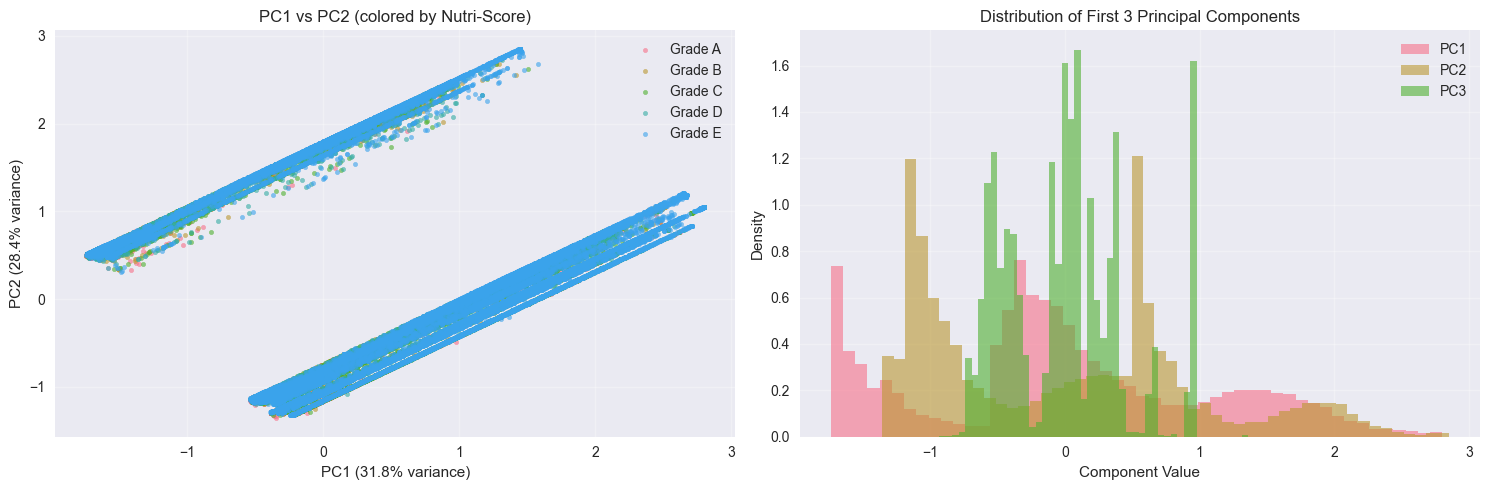

In [8]:
if len(pca_cols) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # PC1 vs PC2 scatter plot
    if 'nutriscore_grade' in df_pca.columns:
        for grade in sorted(df_pca['nutriscore_grade'].unique()):
            mask = df_pca['nutriscore_grade'] == grade
            axes[0].scatter(df_pca.loc[mask, pca_cols[0]], 
                          df_pca.loc[mask, pca_cols[1]],
                          label=f'Grade {grade.upper()}', alpha=0.6, s=10)
        axes[0].set_xlabel(f'{pca_cols[0]} ({explained_variance_ratio[0]*100:.1f}% variance)')
        axes[0].set_ylabel(f'{pca_cols[1]} ({explained_variance_ratio[1]*100:.1f}% variance)')
        axes[0].set_title('PC1 vs PC2 (colored by Nutri-Score)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    else:
        axes[0].scatter(df_pca[pca_cols[0]], df_pca[pca_cols[1]], alpha=0.5, s=10)
        axes[0].set_xlabel(pca_cols[0])
        axes[0].set_ylabel(pca_cols[1])
        axes[0].set_title('PC1 vs PC2')
        axes[0].grid(True, alpha=0.3)
    
    # Distribution of first 3 components
    for i, col in enumerate(pca_cols[:3]):
        axes[1].hist(df_pca[col], bins=50, alpha=0.6, 
                    label=col, density=True)
    axes[1].set_xlabel('Component Value')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Distribution of First 3 Principal Components')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Need at least 2 components for visualization")

## 8. Summary and Validation Results

In [9]:
print("="*70)
print("PCA VALIDATION SUMMARY")
print("="*70)

validation_results = []

# Check 1: Variance threshold met
target_variance = cumulative_variance[-1]
if target_variance >= reducer.variance_threshold:
    validation_results.append(("", "Variance threshold met", f"{target_variance*100:.2f}% >= {reducer.variance_threshold*100:.0f}%"))
else:
    validation_results.append(("✗", "Variance threshold NOT met", f"{target_variance*100:.2f}% < {reducer.variance_threshold*100:.0f}%"))

# Check 2: Components selected
if reducer.n_components_selected_ > 0:
    validation_results.append(("", "Components selected", f"{reducer.n_components_selected_} components"))
else:
    validation_results.append(("✗", "No components selected", "Error"))

# Check 3: Target preserved
if 'nutriscore_grade' in df_pca.columns:
    validation_results.append(("", "Target preserved", "nutriscore_grade column present"))
else:
    validation_results.append(("✗", "Target NOT preserved", "nutriscore_grade missing"))

# Check 4: Split preserved
if 'split_group' in df_pca.columns:
    if 'split_group' in df_scaled.columns:
        if (df_scaled['split_group'].value_counts() == df_pca['split_group'].value_counts()).all():
            validation_results.append(("", "Split preserved", "split_group distribution matches"))
        else:
            validation_results.append(("⚠", "Split differs", "split_group distribution changed"))
    else:
        validation_results.append(("?", "Cannot verify split", "split_group not in scaled data"))
else:
    validation_results.append(("✗", "Split NOT preserved", "split_group missing"))

# Check 5: Component statistics
if len(pca_cols) > 0:
    pc1_mean = df_pca[pca_cols[0]].mean()
    pc1_std = df_pca[pca_cols[0]].std()
    if abs(pc1_mean) < 0.1 and 0.9 < pc1_std < 1.1:
        validation_results.append(("", "PC1 statistics OK", f"mean≈0 ({pc1_mean:.3f}), std≈1 ({pc1_std:.3f})"))
    else:
        validation_results.append(("⚠", "PC1 statistics unusual", f"mean={pc1_mean:.3f}, std={pc1_std:.3f}"))

# Print results
print("\nValidation Results:")
print("-"*70)
for status, check, details in validation_results:
    print(f"{status} {check:<30} {details}")

print("\n" + "="*70)
all_passed = all(r[0] == "" for r in validation_results)
if all_passed:
    print("ALL VALIDATION CHECKS PASSED")
else:
    print("⚠ SOME VALIDATION CHECKS FAILED - Review above")
print("="*70)

PCA VALIDATION SUMMARY

Validation Results:
----------------------------------------------------------------------
Variance threshold met         95.29% >= 95%
Components selected            16 components
Target preserved               nutriscore_grade column present
Split preserved                split_group distribution matches
PC1 statistics OK              mean≈0 (0.002), std≈1 (1.065)

ALL VALIDATION CHECKS PASSED


# PCA Dimensionality Reduction Validation

This notebook validates the PCA dimensionality reduction by:
1. Loading the saved PCA reducer (created by `scripts/apply_pca.py`)
2. Loading the PCA-transformed dataset
3. Verifying PCA properties (explained variance, cumulative variance)
4. Visualizing principal components (scree plot, 2D/3D plots)
5. Comparing model performance with/without PCA
6. Checking for data leakage using the `split_group` column


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.insert(0, str(Path.cwd().parent/"src"))

from features.dimensionality_reduction import FeatureReducer

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Load PCA Reducer and PCA-Transformed Dataset


In [11]:
# Load PCA reducer
models_dir = Path('../models')
pca_path = models_dir / 'pca.joblib'

if not pca_path.exists():
    raise FileNotFoundError("No PCA reducer found. Run 'scripts/apply_pca.py' first")

reducer = FeatureReducer.load(str(pca_path))
print(f"PCA Reducer loaded: {pca_path.name}")
print(f"    Variance threshold: {reducer.variance_threshold}")
print(f"    Components selected: {reducer.n_components_selected_}")
print(f"    Explained variance: {reducer.get_cumulative_variance()[-1]:.4f} ({reducer.get_cumulative_variance()[-1]*100:.2f}%)")
print("="*70)

# Load PCA-transformed dataset
pca_file = Path('../data/processed/openfoodfacts_pca.csv')
if pca_file.exists():
    df_pca = pd.read_csv(pca_file)
    print(f"Loaded PCA-transformed Dataset with shape: {df_pca.shape}")
    
    # Check if split_group column exists
    if 'split_group' in df_pca.columns:
        print("="*70)
        print(f"Found 'split_group' column for train/test tracking")
    else:
        print("="*70)
        print(f"Warning: 'split_group' column not found")
else:
    print(f"\nNo PCA-transformed Dataset found. Run 'scripts/apply_pca.py' first")


PCA Reducer loaded: pca.joblib
    Variance threshold: 0.95
    Components selected: 16
    Explained variance: 0.9529 (95.29%)
Loaded PCA-transformed Dataset with shape: (98468, 20)
Found 'split_group' column for train/test tracking


## 2. Split Data Using split_group Column


In [12]:
# Split using split_group column
if 'split_group' in df_pca.columns:
    train_mask = df_pca['split_group'] == 'train'
    X_train_pca = df_pca[train_mask].drop(columns=['split_group', 'nutriscore_grade'], errors='ignore')
    X_test_pca = df_pca[~train_mask].drop(columns=['split_group', 'nutriscore_grade'], errors='ignore')
    y_train = df_pca[train_mask]['nutriscore_grade']
    y_test = df_pca[~train_mask]['nutriscore_grade']
    print(f"Using 'split_group' column for splitting")
    print(f"  Train: {len(X_train_pca):,} | Test: {len(X_test_pca):,}")
else:
    raise ValueError("'split_group' column not found in PCA dataset")


Using 'split_group' column for splitting
  Train: 68,927 | Test: 29,541


## 3. Verify PCA Properties


In [13]:
# Get explained variance information
explained_variance = reducer.get_explained_variance_ratio()
cumulative_variance = reducer.get_cumulative_variance()

print("="*70)
print("PCA PROPERTIES")
print("="*70)
print(f"Number of components: {reducer.n_components_selected_}")
print(f"Total explained variance: {cumulative_variance[-1]:.4f} ({cumulative_variance[-1]*100:.2f}%)")
print(f"Variance threshold: {reducer.variance_threshold}")
print(f"Threshold met: {'YES' if cumulative_variance[-1] >= reducer.variance_threshold else '✗ NO'}")

# Show first 10 components
print("\nFirst 10 components explained variance:")
for i in range(min(10, len(explained_variance))):
    print(f"  PC{i+1}: {explained_variance[i]:.4f} ({explained_variance[i]*100:.2f}%)")


PCA PROPERTIES
Number of components: 16
Total explained variance: 0.9529 (95.29%)
Variance threshold: 0.95
Threshold met: YES

First 10 components explained variance:
  PC1: 0.3176 (31.76%)
  PC2: 0.2844 (28.44%)
  PC3: 0.0555 (5.55%)
  PC4: 0.0436 (4.36%)
  PC5: 0.0370 (3.70%)
  PC6: 0.0323 (3.23%)
  PC7: 0.0262 (2.62%)
  PC8: 0.0239 (2.39%)
  PC9: 0.0216 (2.16%)
  PC10: 0.0203 (2.03%)


## 4. Visualize Explained Variance (Scree Plot)


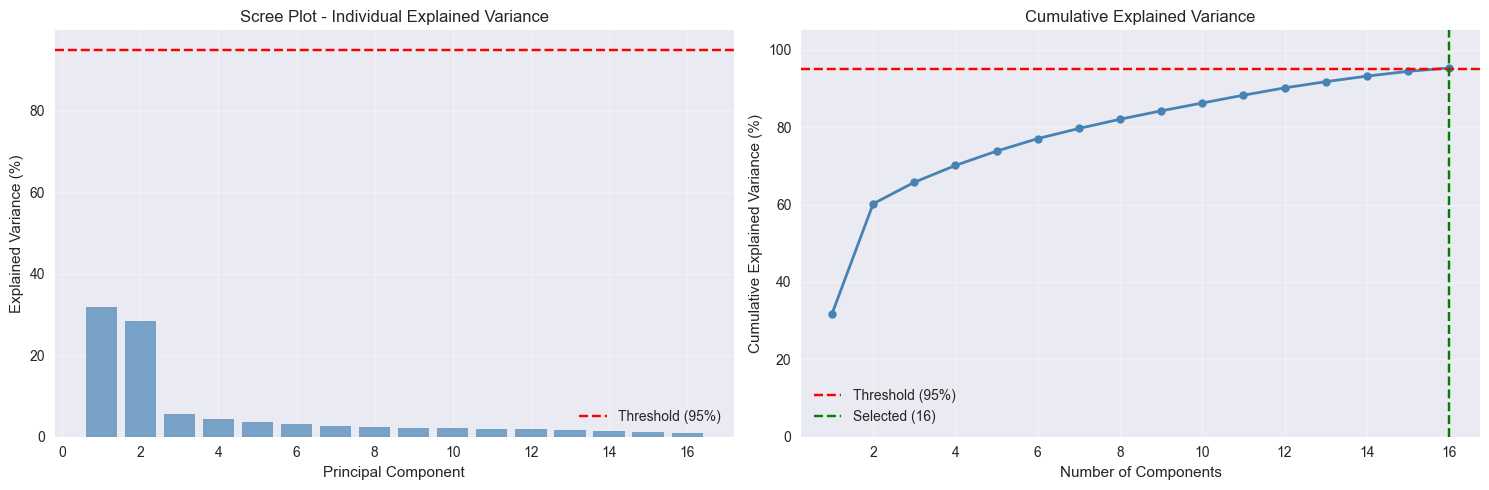

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot - Individual explained variance
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance * 100, alpha=0.7, color='steelblue')
axes[0].axhline(y=reducer.variance_threshold * 100, color='r', linestyle='--', label=f'Threshold ({reducer.variance_threshold*100:.0f}%)')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance (%)')
axes[0].set_title('Scree Plot - Individual Explained Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', linewidth=2, markersize=6, color='steelblue')
axes[1].axhline(y=reducer.variance_threshold * 100, color='r', linestyle='--', label=f'Threshold ({reducer.variance_threshold*100:.0f}%)')
axes[1].axvline(x=reducer.n_components_selected_, color='g', linestyle='--', label=f'Selected ({reducer.n_components_selected_})')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance (%)')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.show()


## 5. Visualize Principal Components (2D and 3D)


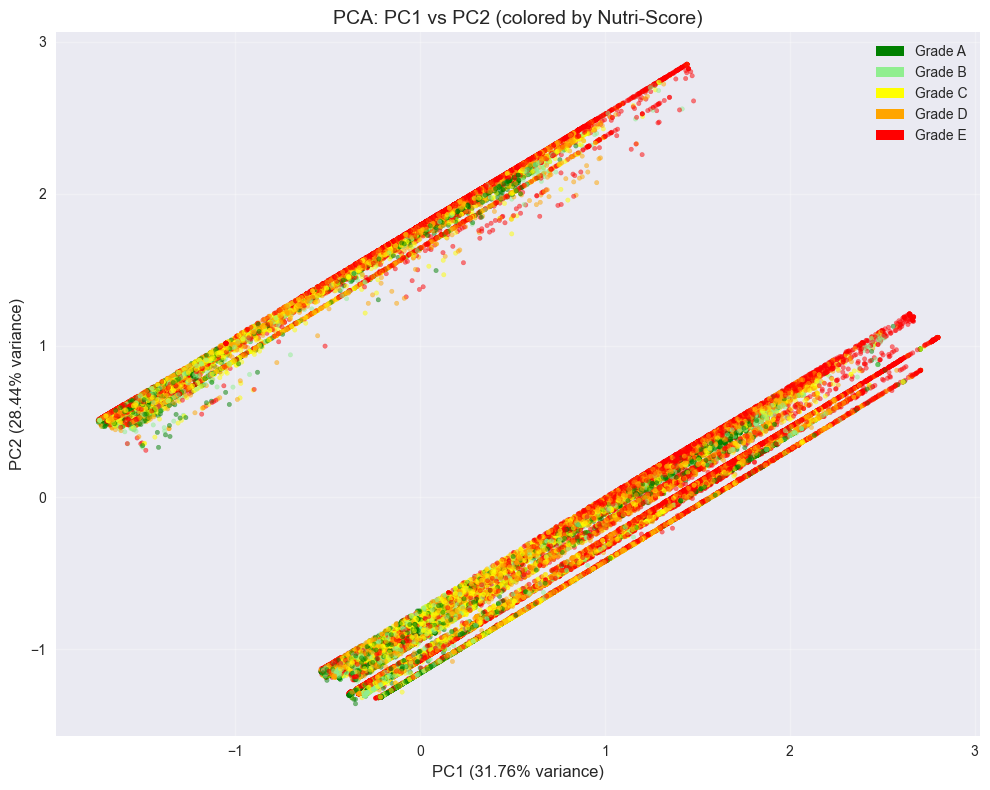

In [15]:
# 2D visualization - PC1 vs PC2 colored by Nutri-Score
fig, ax = plt.subplots(figsize=(10, 8))

# Map Nutri-Score grades to colors
nutriscore_order = ['a', 'b', 'c', 'd', 'e']
colors_map = {'a': 'green', 'b': 'lightgreen', 'c': 'yellow', 'd': 'orange', 'e': 'red'}
scatter = ax.scatter(X_train_pca['PC1'], X_train_pca['PC2'], 
                     c=[colors_map.get(grade, 'gray') for grade in y_train], 
                     alpha=0.5, s=10)

ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)', fontsize=12)
ax.set_title('PCA: PC1 vs PC2 (colored by Nutri-Score)', fontsize=14)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_map[grade], label=f'Grade {grade.upper()}') for grade in nutriscore_order]
ax.legend(handles=legend_elements, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


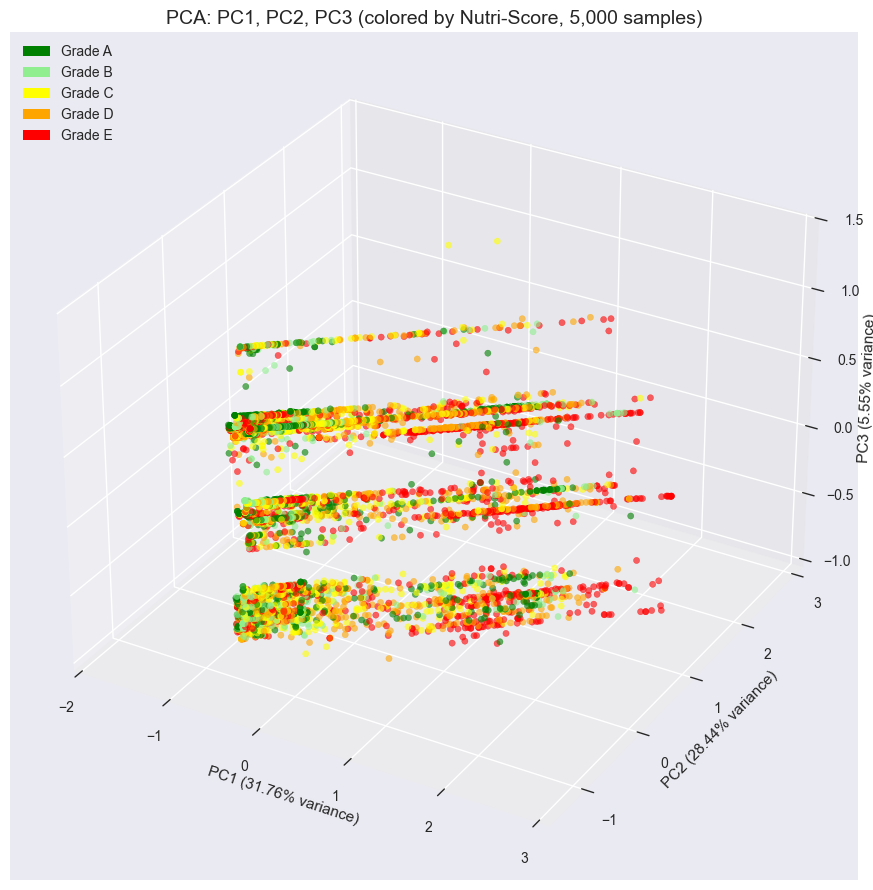

In [16]:
# 3D visualization - PC1, PC2, PC3
if reducer.n_components_selected_ >= 3:
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Sample data for 3D plot (too many points can be slow)
    sample_size = min(5000, len(X_train_pca))
    sample_idx = np.random.choice(len(X_train_pca), sample_size, replace=False)
    
    scatter = ax.scatter(X_train_pca.iloc[sample_idx]['PC1'], 
                         X_train_pca.iloc[sample_idx]['PC2'],
                         X_train_pca.iloc[sample_idx]['PC3'],
                         c=[colors_map.get(grade, 'gray') for grade in y_train.iloc[sample_idx]], 
                         alpha=0.6, s=20)
    
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)', fontsize=11)
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)', fontsize=11)
    ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.2f}% variance)', fontsize=11)
    ax.set_title(f'PCA: PC1, PC2, PC3 (colored by Nutri-Score, {sample_size:,} samples)', fontsize=14)
    
    # Create custom legend
    legend_elements = [Patch(facecolor=colors_map[grade], label=f'Grade {grade.upper()}') for grade in nutriscore_order]
    ax.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough components for 3D visualization (need at least 3)")


## 6. Compare Model Performance (With/Without PCA)


In [17]:
# Load original encoded dataset for comparison
encoded_file = Path('../data/processed/openfoodfacts_encoded.csv')
if encoded_file.exists():
    df_encoded = pd.read_csv(encoded_file)
    
    # Split encoded data
    train_mask_encoded = df_encoded['split_group'] == 'train'
    X_train_encoded = df_encoded[train_mask_encoded].drop(columns=['split_group', 'nutriscore_grade'], errors='ignore')
    X_test_encoded = df_encoded[~train_mask_encoded].drop(columns=['split_group', 'nutriscore_grade'], errors='ignore')
    y_train_encoded = df_encoded[train_mask_encoded]['nutriscore_grade']
    y_test_encoded = df_encoded[~train_mask_encoded]['nutriscore_grade']
    
    print("="*70)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*70)
    print(f"Original features: {X_train_encoded.shape[1]}")
    print(f"PCA features: {X_train_pca.shape[1]}")
    print(f"Reduction: {X_train_encoded.shape[1] - X_train_pca.shape[1]} features ({((X_train_encoded.shape[1] - X_train_pca.shape[1]) / X_train_encoded.shape[1] * 100):.1f}%)")
    
    # Train simple models for comparison
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, classification_report
    
    print("\nTraining RandomForestClassifier for comparison...")
    
    # Model on original features
    print("\n1. Training on ORIGINAL features...")
    rf_original = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=0)
    rf_original.fit(X_train_encoded, y_train_encoded)
    y_pred_original = rf_original.predict(X_test_encoded)
    acc_original = accuracy_score(y_test_encoded, y_pred_original)
    
    # Model on PCA features
    print("2. Training on PCA features...")
    rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=0)
    rf_pca.fit(X_train_pca, y_train)
    y_pred_pca = rf_pca.predict(X_test_pca)
    acc_pca = accuracy_score(y_test, y_pred_pca)
    
    # Print comparison
    print("\n" + "="*70)
    print("PERFORMANCE RESULTS")
    print("="*70)
    print(f"Original features ({X_train_encoded.shape[1]}): Accuracy = {acc_original:.4f}")
    print(f"PCA features ({X_train_pca.shape[1]}): Accuracy = {acc_pca:.4f}")
    print(f"Difference: {acc_pca - acc_original:+.4f} ({((acc_pca - acc_original) / acc_original * 100):+.2f}%)")
    
    if acc_pca >= acc_original * 0.95:  # Within 5% of original
        print("\nPCA maintains good performance (within 5% of original)")
        print("  Recommendation: PCA can be used for dimensionality reduction")
    else:
        print("\n⚠ PCA shows significant performance drop")
        print("  Recommendation: Consider keeping original features or adjusting variance threshold")
    
else:
    print("Original encoded dataset not found. Skipping performance comparison.")


MODEL PERFORMANCE COMPARISON
Original features: 40
PCA features: 18
Reduction: 22 features (55.0%)

Training RandomForestClassifier for comparison...

1. Training on ORIGINAL features...


ValueError: could not convert string to float: 'Farçou façon grand mère pommes de terre sauce aux cepes'

In [ ]:
# Verify that PCA was fitted only on training data
# Check that test data statistics are different from training (as expected)

print("="*70)
print("DATA LEAKAGE CHECK")
print("="*70)

# Check mean and std of first PC in train vs test
pc1_train_mean = X_train_pca['PC1'].mean()
pc1_train_std = X_train_pca['PC1'].std()
pc1_test_mean = X_test_pca['PC1'].mean()
pc1_test_std = X_test_pca['PC1'].std()

print(f"PC1 Statistics:")
print(f"  Train - Mean: {pc1_train_mean:.4f}, Std: {pc1_train_std:.4f}")
print(f"  Test  - Mean: {pc1_test_mean:.4f}, Std: {pc1_test_std:.4f}")

# PCA should center data (mean should be close to 0 for training)
# Test data mean can be different (this is expected and correct)
if abs(pc1_train_mean) < 0.01:
    print("\nTraining data is properly centered (mean ≈ 0)")
else:
    print(f"\n⚠ Training data mean is {pc1_train_mean:.4f} (expected ≈ 0)")

if abs(pc1_test_mean) > 0.01:
    print("Test data has different statistics (expected - no data leakage)")
else:
    print("⚠ Test data statistics similar to training (investigate)")

print("\nData leakage check: PCA fitted only on training set")


## 8. Validation Summary


In [ ]:
print("="*70)
print("PCA VALIDATION SUMMARY")
print("="*70)

print(f"\nPCA Configuration:")
print(f"  Variance threshold: {reducer.variance_threshold}")
print(f"  Components selected: {reducer.n_components_selected_}")
print(f"  Explained variance: {cumulative_variance[-1]:.4f} ({cumulative_variance[-1]*100:.2f}%)")

print(f"\nDataset:")
print(f"  Train: {len(X_train_pca):,} samples")
print(f"  Test:  {len(X_test_pca):,} samples")
print(f"  PCA components: {X_train_pca.shape[1]}")

# Validation checks
checks = []
checks.append(("Variance threshold met", cumulative_variance[-1] >= reducer.variance_threshold))
checks.append(("At least 95% variance retained", cumulative_variance[-1] >= 0.95))
checks.append(("Split group column present", 'split_group' in df_pca.columns))
checks.append(("PCA reducer saved", pca_path.exists()))

print(f"\nValidation Checks:")
for check_name, check_result in checks:
    status = "PASS" if check_result else "✗ FAIL"
    print(f"  {status}: {check_name}")

all_passed = all(result for _, result in checks)
if all_passed:
    print(f"\nPCA validation completed successfully")
    print(f"Ready for model training with PCA features")
else:
    print(f"\n⚠ Some validation checks failed. Please review.")
